In [ ]:
import pyro

In [ ]:
import torch

In [ ]:
true_coefs = torch.tensor([1., 2., 3.])

In [ ]:
data = torch.randn(2000, 3)

In [ ]:
dim = 3

In [ ]:
import pyro.distributions as dist

In [ ]:
labels = dist.Bernoulli(logits=(true_coefs * data).sum(-1)).sample()

In [ ]:
((true_coefs * data).sum(-1)).shape

In [ ]:
coefs_mean = torch.zeros(dim)
coefs_mean

In [ ]:
coefs = pyro.sample('beta', dist.Normal(coefs_mean, torch.ones(3)))


In [ ]:
coefs # random coeffs sampled from beta distr

In [ ]:
y = pyro.sample('y', dist.Bernoulli(logits=(coefs * data).sum(-1)), obs=labels)

In [ ]:
y[1:100]

In [ ]:
labels[1:100]

In [ ]:
(labels == y).sum()

In [ ]:
y.shape

# Random Normal Data

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import torch
import numpy as np

In [ ]:
data = torch.randn(1000)

In [ ]:
def custom_likelihood(data, params):
    # Ensure data is a PyTorch tensor
    mu, sigma = params
    if sigma <= 0:
        raise ValueError("Sigma must be positive.")

    n = data.shape[0]
    log_likelihood = -n / 2 * torch.log(torch.tensor(2 * torch.pi)) - n * torch.log(sigma) - (1 / (2 * sigma**2)) * torch.sum((data - mu)**2)
    if torch.isnan(log_likelihood) or torch.isinf(log_likelihood):
        raise ValueError("Log-likelihood is NaN or infinite.")

    return log_likelihood



def model(data):
    # Prior distributions for parameters
    mu = pyro.sample("mu", dist.Normal(-0.5, 0.5))
    sigma = pyro.sample("sigma", dist.LogNormal(1.8, 2.2))
    print(f'Sampled mu: {mu}, sigma: {sigma}')
    log_likelihood = custom_likelihood(data, (mu, sigma))

    print(f'Log Likelihood: {log_likelihood}')

    pyro.sample("obs", dist.Delta(log_likelihood), obs=data)

nuts_kernel = NUTS(model, adapt_step_size=True)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(data)


# define using potential func

In [27]:
import torch

# Generate 1000 samples from a standard normal distribution
data = torch.normal(mean=0, std=2.5, size=(1000,))


In [2]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS


In [30]:
def potential_fn(params):
    # mean and sigma should be torch tensors check that
    assert isinstance(params["mean"], torch.Tensor)
    assert isinstance(params["sigma"], torch.Tensor)

    mu = params["mean"]
    sigma = params["sigma"]

    # Prior for mean and std
    mean_prior = dist.Uniform(-1., 1.)
    sigma_prior = dist.Uniform(0.5, 5.)

    # Compute the log probability of the priors
    log_prior = mean_prior.log_prob(mu) + sigma_prior.log_prob(sigma)

    # Compute the log likelihood
    n = data.shape[0]
    log_likelihood = -n / 2 * torch.log(torch.tensor(2 * torch.pi)) - n * torch.log(sigma) - (1 / (2 * sigma**2)) * torch.sum((data - mu)**2)

    # Compute the negative log posterior (potential energy)
    return -(log_prior + log_likelihood)


nuts_kernel = NUTS(potential_fn=potential_fn)
initial_params = {
    "mean": torch.tensor(0.),
    "sigma": torch.tensor(1.)
}

mcmc = MCMC(
    nuts_kernel,
    num_samples=10000,
    warmup_steps=500,
    num_chains = 1,
    initial_params=initial_params
)

mcmc.run()

Warmup:   0%|          | 0/10500 [00:00, ?it/s]

Sample: 100%|██████████| 10500/10500 [00:45, 228.50it/s, step size=8.53e-01, acc. prob=0.917]


In [31]:
samples = mcmc.get_samples()

In [32]:
mean_tensor, sigma_tensor  = samples['mean'], samples['sigma']
# convert torch to numpy arrs
mean_arr = mean_tensor.detach().numpy()
sigma_arr = sigma_tensor.detach().numpy()

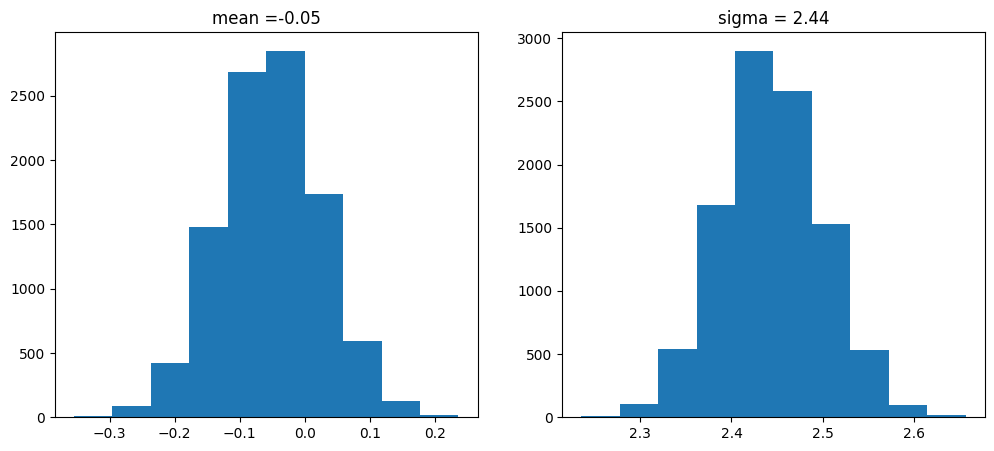

In [36]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.hist(mean_arr); plt.title(f'mean ={np.mean(mean_arr): .2f}')
plt.subplot(1,2,2)
plt.hist(sigma_arr); plt.title(f'sigma ={np.mean(sigma_arr) : .2f}');

# Move to CUDA?

In [41]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS


# Generate 1000 samples from a standard normal distribution
data = torch.normal(mean=0, std=2.5, size=(1000,))


In [42]:
def potential_fn(params):
    # mean and sigma should be torch tensors check that
    assert isinstance(params["mean"], torch.Tensor)
    assert isinstance(params["sigma"], torch.Tensor)

    mu = params["mean"]
    sigma = params["sigma"]

    # Prior for mean and std
    mean_prior = dist.Uniform(-1., 1.)
    sigma_prior = dist.Uniform(0.5, 5.)

    # Compute the log probability of the priors
    log_prior = mean_prior.log_prob(mu) + sigma_prior.log_prob(sigma)

    # Compute the log likelihood
    n = data.shape[0]
    log_likelihood = -n / 2 * torch.log(torch.tensor(2 * torch.pi)) - n * torch.log(sigma) - (1 / (2 * sigma**2)) * torch.sum((data - mu)**2)

    # Compute the negative log posterior (potential energy)
    return -(log_prior + log_likelihood)


nuts_kernel = NUTS(potential_fn=potential_fn)
initial_params = {
    "mean": torch.tensor(0.),
    "sigma": torch.tensor(1.)
}

mcmc = MCMC(
    nuts_kernel,
    num_samples=10000,
    warmup_steps=500,
    num_chains = 1,
    initial_params=initial_params
)

mcmc.run()

Sample: 100%|██████████| 10500/10500 [00:49, 213.50it/s, step size=8.94e-01, acc. prob=0.923]
